# Unsupervised anomaly detection algorithm

This notebook has good example algorithms to do a forensic-type analysis, looking for anomalies in a dataset. We first do some data cleaning (exclusions, imputation), then build variables that are designed to look for the kinds of anomalies we are interested in, in this case, unusual property valuations.

After we build the variables we know we have lots of correlations and too high dimensionality so we need to remove correlations and reduce dimensionality. Since we don't have a dependent variable the easiest useful thing to do is PCA. We z scale, do PCA, keep the top PCs, then z scale again in order to make each retained PC equally important (optional step).

We use two different anamaly detection (fraud) algorithms. The first just looks for outliers in the final scaled PC space using a Minkowski distance from the origin. The second method makes a simple autoencoder and the fraud score is then the reproduction error. It's important to note that each/either of these two methods would be a fine fraud score by itself.

Since we have two score and we don't really know which one is better we just average the two scores. To do this we replace the score with its rank order and then average the rank-ordered scores for our final score.

Finally we sort all the records by this final score and explore the top n records. To help the investigation we show which of the variables are driving these top scoring records with a heat map of the variable zscores, which can point the investigators to what's making the high score for these top scoring records.

This problem is an invented problem to demonstrate the process of building unsupervised fraud models. The data set is real and the invented problem is realistic. What's lacking the most is the ability to interact with domain experts in order to do proper exclusions and design good/appropriate variables.

The data can be found here: https://data.cityofnewyork.us/Housing-Development/Property-Valuation-and-Assessment-Data/rgy2-tti8

In [1]:
from datetime import datetime
start_time = datetime.now()

# Load libraries
# %pip install openpyxl
# %pip install xlwt

from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

print('LOAD DURATION:',datetime.now() - start_time) # about 3 seconds

LOAD DURATION: 0:00:02.214344


In [2]:
%%time
data = pd.read_csv('NY property data.csv')
NY_data_orig = data.copy()
data.shape

CPU times: user 3.96 s, sys: 2.15 s, total: 6.11 s
Wall time: 6.13 s


(1070994, 32)

In [3]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT       int64
LTDEPTH       int64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT      int64
BLDDEPTH      int64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [4]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


## Remove some benign properties that we aren't interested in
There are certainly better ways to do this, and this important step can/should be improved.

In [5]:
# first look at the most frequent owners
remove_list = data['OWNER'].value_counts().head(20).index.tolist()
remove_list

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'YORKVILLE TOWERS ASSO',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 '434 M LLC',
 'LINCOLN PLAZA ASSOCIA',
 'DEUTSCHE BANK NATIONA',
 '561 11TH AVENUE TMG L']

In [6]:
# remove some of these and add some others to also be removed
remove_list.remove('YORKVILLE TOWERS ASSO')
remove_list.remove('434 M LLC')
remove_list.remove('DEUTSCHE BANK NATIONA')
remove_list.remove('561 11TH AVENUE TMG L')
remove_list.append('UNITED STATES OF AMER')
remove_list.append('U S GOVERNMENT OWNRD')
remove_list.append('THE CITY OF NEW YORK')
remove_list.append('NYS URBAN DEVELOPMENT')
remove_list.append('NYS DEPT OF ENVIRONME')
remove_list.append('CULTURAL AFFAIRS')
remove_list.append('DEPT OF GENERAL SERVI')
remove_list.append('DEPT RE-CITY OF NY')
remove_list

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 'LINCOLN PLAZA ASSOCIA',
 'UNITED STATES OF AMER',
 'U S GOVERNMENT OWNRD',
 'THE CITY OF NEW YORK',
 'NYS URBAN DEVELOPMENT',
 'NYS DEPT OF ENVIRONME',
 'CULTURAL AFFAIRS',
 'DEPT OF GENERAL SERVI',
 'DEPT RE-CITY OF NY']

In [7]:
property_data = data[~data['OWNER'].isin(remove_list)].reset_index(drop=True)
property_data.shape

(1046826, 32)

In [8]:
data.shape

(1070994, 32)

In [9]:
# this is how many records we removed
len(data) - len(property_data)

24168

In [10]:
numrecs = len(property_data)

## Fill in missing ZIP

In [11]:
# How many zips are missing? Replace NAN with 0 and count them.
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

21772

In [12]:
# Assume the data is already sorted by zip. If a zip is missing, 
# and the before and after zips are the same, fill in the zip with that value
for i in range(len(missing_zips)):
    if(property_data.loc[missing_zips[i]+1,'ZIP'] == property_data.loc[missing_zips[i]-1,'ZIP']):
        property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [13]:
# How many are still left to fill in?
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

10245

In [14]:
# For the remaining missing zips, just fill in with the previous record's zip.
for i in range(len(missing_zips)):
    property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [15]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

0

## Calculate means for AVTOT, AVLAND, FULLVAL by taxclass, avoiding the records with zeros

In [16]:
property_data['FULLVAL'].replace('NaN',0)
temp =property_data[property_data['FULLVAL']!=0]
mean_fullval = temp.groupby('TAXCLASS')['FULLVAL'].mean()
print(mean_fullval)

TAXCLASS
1     5.700059e+05
1A    3.352942e+05
1B    3.738399e+05
1C    7.615359e+05
1D    2.233614e+07
2     8.005832e+05
2A    8.639066e+05
2B    1.254525e+06
2C    7.723493e+05
3     8.510005e+04
4     2.772747e+06
Name: FULLVAL, dtype: float64


In [17]:
property_data['AVLAND'].replace('NaN',0)
temp_avland = property_data[property_data['AVLAND']!=0]
mean_avland = temp_avland.groupby('TAXCLASS')['AVLAND'].mean()

In [18]:
property_data['AVTOT'].replace('NaN',0)
temp_avtot = property_data[property_data['AVTOT']!=0]
mean_avtot = temp_avtot.groupby('TAXCLASS')['AVTOT'].mean()

## Substituting decent values for AVTOT, AVLAND, FULLVAL from averages by taxclass

In [19]:
%%time
for index in mean_fullval.index:
    property_data.loc[(property_data['FULLVAL']==0)&(property_data['TAXCLASS']==index),'FULLVAL']=mean_fullval[index]
    property_data.loc[(property_data['AVLAND']==0)&(property_data['TAXCLASS']==index),'AVLAND']=mean_avland[index]
    property_data.loc[(property_data['AVTOT']==0)&(property_data['TAXCLASS']==index),'AVTOT']=mean_avtot[index]

CPU times: user 1.48 s, sys: 14.4 ms, total: 1.5 s
Wall time: 1.45 s


In [20]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


## Fill in the missing STORIES

In [21]:
temp = property_data[property_data['STORIES'].isnull()]
len(temp)

43968

In [22]:
temp['TAXCLASS'].value_counts()

1B    19055
4     17979
2      3434
3      2416
1       877
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [23]:
mean_stories = property_data.groupby('TAXCLASS')['STORIES'].mean()
print(mean_stories)

TAXCLASS
1      2.111633
1A     1.656867
1B     4.000000
1C     3.052748
1D     1.068966
2     16.310549
2A     2.844032
2B     4.001635
2C     4.744977
3      1.000000
4      5.517257
Name: STORIES, dtype: float64


In [24]:
temp.head().transpose()

,0,1,59,60,61
RECORD,1,2,66,67,68
BBLE,1000010101,1000010201,1000051004,1000051005,1000051006
BORO,1,1,1,1,1
BLOCK,1,1,5,5,5
LOT,101,201,1004,1005,1006
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,SLG BROAD STREET 125,AMERICAN CIVIL LIBERT,SLG BROAD STREET 125
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


In [25]:
len(property_data[property_data["STORIES"]==0])

0

In [26]:
property_data['STORIES']=property_data['STORIES'].fillna(value =0)
for index in mean_stories.index:
    property_data.loc[(property_data['STORIES']==0)&(property_data['TAXCLASS']==index),'STORIES']=mean_stories[index]

In [27]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


## Fill in LTFRONT, LTDEPTH, BLDDEPTH, BLDFRONT with averages by TAXCLASS

In [28]:
# Because these 4 fields do not have NAs, we just need to replace 0s. 
# We think zero and 1 are invalid values for these fields, so replace them wiht NA.
# Calculate groupwise average. Replace 0 and 1's by NAs so they are not counted in calculating mean.
property_data.loc[property_data['LTFRONT']==0,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==0,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==0,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
property_data.loc[property_data['LTFRONT']==1,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==1,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==1,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

# Calculate mean now (mean function ignores NAs but not 0s hence we converted 0 to NA)
mean_LTFRONT=property_data.groupby(property_data['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=property_data.groupby(property_data['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=property_data.groupby(property_data['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=property_data.groupby(property_data['TAXCLASS'])['BLDDEPTH'].mean()

# Now impute values with the average for that record's TAXCLASS
for index in mean_LTFRONT.index:
    property_data.loc[(property_data['LTFRONT'].isnull())&(property_data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]    
    property_data.loc[(property_data['LTDEPTH'].isnull())&(property_data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]
    property_data.loc[(property_data['BLDFRONT'].isnull())&(property_data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]
    property_data.loc[(property_data['BLDDEPTH'].isnull())&(property_data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]

In [29]:
mean_LTFRONT

TAXCLASS
1      30.939210
1A     51.130890
1B     46.316982
1C     27.250825
1D    338.275862
2     111.579150
2A     25.919459
2B     27.254800
2C     29.988866
3     154.473171
4      82.296384
Name: LTFRONT, dtype: float64

In [30]:
mean_LTDEPTH

TAXCLASS
1      99.279091
1A     90.095778
1B    103.993512
1C     96.778878
1D    497.827586
2     130.815876
2A     97.288381
2B     95.725639
2C     95.748523
3     274.124729
4     124.443774
Name: LTDEPTH, dtype: float64

In [31]:
mean_BLDFRONT

TAXCLASS
1     21.403255
1A    25.026348
1B    39.500000
1C    23.367589
1D    19.586207
2     91.495779
2A    22.985669
2B    26.033148
2C    27.887084
3     10.000000
4     62.082133
Name: BLDFRONT, dtype: float64

In [32]:
mean_BLDDEPTH

TAXCLASS
1      41.560577
1A     44.952387
1B     82.666667
1C     60.094862
1D     36.862069
2     104.282570
2A     62.435640
2B     66.521339
2C     68.657523
3      17.500000
4      86.296710
Name: BLDDEPTH, dtype: float64

In [33]:
data = property_data.copy()
data.shape

(1046826, 32)

In [34]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT     float64
LTDEPTH     float64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT    float64
BLDDEPTH    float64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [35]:
# convert ZIP to a string rather than a float
# We call the first three digits of the zip zip3
data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]

In [36]:
data.count()

RECORD      1046826
BBLE        1046826
BORO        1046826
BLOCK       1046826
LOT         1046826
EASEMENT       2967
OWNER       1015081
BLDGCL      1046826
TAXCLASS    1046826
LTFRONT     1046826
LTDEPTH     1046826
EXT          353372
STORIES     1046826
FULLVAL     1046826
AVLAND      1046826
AVTOT       1046826
EXLAND      1046826
EXTOT       1046826
EXCD1        625308
STADDR      1046357
ZIP         1046826
EXMPTCL       10681
BLDFRONT    1046826
BLDDEPTH    1046826
AVLAND2      267417
AVTOT2       267423
EXLAND2       82371
EXTOT2       119371
EXCD2         92912
PERIOD      1046826
YEAR        1046826
VALTYPE     1046826
zip3        1046826
dtype: int64

In [37]:
cols = data.columns
print(cols)

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3'],
      dtype='object')


### Now build the variables

In [38]:
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH']
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH']
data['bldvol'] = data['bldsize'] * data['STORIES']

In [39]:
data['r1'] = data['FULLVAL'] / data['ltsize']
data['r2'] = data['FULLVAL'] / data['bldsize']
data['r3'] = data['FULLVAL'] / data['bldvol']
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize']
data['r6'] = data['AVLAND'] / data['bldvol']
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize']
data['r9'] = data['AVTOT'] / data['bldvol']

In [40]:
# add in the inverse of all the 9 primary variables
for col in data.columns[36:]:
    data[col+'inv'] = 1/(data[col])

In [41]:
vars18 = ['r1','r2','r3','r4','r5','r6','r7','r8','r9',
          'r1inv','r2inv','r3inv','r4inv','r5inv','r6inv','r7inv','r8inv','r9inv']
zip5_mean = data.groupby('ZIP')[vars18].mean()
zip3_mean = data.groupby('zip3')[vars18].mean()
taxclass_mean = data.groupby('TAXCLASS')[vars18].mean()
borough_mean = data.groupby('BORO')[vars18].mean()
data = data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
data = data.join(zip3_mean, on='zip3', rsuffix='_zip3')
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')
data = data.join(borough_mean, on='BORO', rsuffix='_boro')
rsuffix = ['_zip5', '_zip3', '_taxclass', '_boro']
for var in vars18:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

In [42]:
data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
...,...,...,...,...,...
r5inv_boro,0.000569,0.000168,0.003782,0.002617,0.002487
r6inv_boro,0.000147,0.000043,0.00883,0.00611,0.005805
r7inv_boro,0.106805,0.000076,0.011346,0.007851,0.004222
r8inv_boro,0.001731,0.000191,0.009388,0.006496,0.003494


In [43]:
data.columns

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT',
       ...
       'r9_boro', 'r1inv_boro', 'r2inv_boro', 'r3inv_boro', 'r4inv_boro',
       'r5inv_boro', 'r6inv_boro', 'r7inv_boro', 'r8inv_boro', 'r9inv_boro'],
      dtype='object', length=126)

In [44]:
save_record = data['RECORD']
save_record.head()

0     1
1     2
2     9
3    10
4    11
Name: RECORD, dtype: int64

In [45]:
dropcols = ['RECORD','BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT',
       'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES',
       'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR',
       'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2',
       'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3','ltsize','bldsize','bldvol']
data = data.drop(columns = dropcols)
data.shape

(1046826, 90)

In [46]:
data.head().transpose()

,0,1,2,3,4
r1,40.917782,57678.882190,385.182796,556.662267,1035.027624
r2,3994.412456,36173.697854,736.308714,1064.105879,1978.540749
r3,723.985188,6556.463990,14.726174,21.282118,39.570815
r4,8.079350,4258.951518,62.110738,89.761892,94.470682
r5,788.709805,2671.030012,118.729804,171.587267,180.588507
...,...,...,...,...,...
r5inv_boro,0.000569,0.000168,0.003782,0.002617,0.002487
r6inv_boro,0.000147,0.000043,0.008830,0.006110,0.005805
r7inv_boro,0.106805,0.000076,0.011346,0.007851,0.004222
r8inv_boro,0.001731,0.000191,0.009388,0.006496,0.003494


In [47]:
# Calculate and write the basic statistics of all the variables to check if everything looks OK
stats = data.describe().transpose()
stats.to_excel('stats_on_vars.xlsx')

In [48]:
# data.to_csv('NY vars.csv', index=False)
data.describe()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,...,r9_boro,r1inv_boro,r2inv_boro,r3inv_boro,r4inv_boro,r5inv_boro,r6inv_boro,r7inv_boro,r8inv_boro,r9inv_boro
count,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,...,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06
mean,2.135691e+02,5.364155e+02,2.440821e+02,1.046467e+01,2.281677e+01,1.004138e+01,2.683329e+01,5.046225e+01,1.907402e+01,1.131511e-01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
std,5.325639e+02,1.027443e+03,4.988230e+02,6.997586e+01,3.785065e+02,1.783286e+02,2.038739e+02,9.322000e+02,3.270238e+02,5.806045e+00,...,1.572688e+01,5.725092e+01,4.466163e+01,4.778748e+01,5.090181e+01,1.959085e+01,2.941052e+01,6.264512e+01,2.475668e+01,2.160514e+01
min,3.905765e-04,7.466192e-04,8.983394e-05,8.333333e-06,2.096125e-04,1.038033e-05,8.333333e-06,3.062474e-04,6.049251e-05,7.213064e-06,...,2.777226e-06,3.022904e-05,3.164322e-05,3.083654e-06,1.382444e-05,4.150239e-06,4.480255e-07,9.526489e-06,4.229670e-06,2.655153e-06
25%,7.626263e+01,2.118164e+02,8.250000e+01,2.354081e+00,6.204263e+00,2.015872e+00,5.281000e+00,1.746754e+01,7.089338e+00,4.112150e-03,...,3.906492e-01,4.793202e-02,2.866668e-02,6.645456e-03,8.307361e-02,5.733016e-02,1.350440e-02,1.464240e-01,8.238668e-02,3.214915e-02
50%,1.528571e+02,5.000000e+02,2.390625e+02,4.596931e+00,1.498098e+01,7.146888e+00,8.579254e+00,2.697736e+01,1.267829e+01,6.542056e-03,...,6.729240e-01,7.304364e-02,4.186098e-02,1.070110e-02,1.409591e-01,7.915880e-02,2.405543e-02,2.982497e-01,1.267765e-01,5.180770e-02
75%,2.431818e+02,6.838235e+02,3.362314e+02,7.225445e+00,2.028646e+01,1.004363e+01,1.352700e+01,3.600000e+01,1.757576e+01,1.311258e-02,...,9.393327e-01,1.399090e-01,8.763088e-02,2.546326e-02,2.591898e-01,1.497378e-01,5.473397e-02,4.890672e-01,2.054876e-01,8.663041e-02
max,1.386373e+05,3.105516e+05,2.275000e+05,2.224980e+04,3.346364e+05,1.115455e+05,6.471185e+04,8.713622e+05,2.904541e+05,2.560318e+03,...,1.381933e+04,3.571187e+04,3.279601e+04,3.711074e+04,4.817898e+04,3.428855e+03,3.095585e+03,5.918176e+04,1.379716e+04,1.030168e+04


In [49]:
# zscale all the variables
data_zs = (data - data.mean()) / data.std()
data_zs_save = data_zs.copy()
data_zs.describe()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,...,r9_boro,r1inv_boro,r2inv_boro,r3inv_boro,r4inv_boro,r5inv_boro,r6inv_boro,r7inv_boro,r8inv_boro,r9inv_boro
count,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,...,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06
mean,-1.836969e-14,-3.051849e-14,-3.560872e-14,7.322379e-16,2.313336e-15,1.985216e-15,-4.578153e-14,-1.491621e-15,-3.817431e-15,-4.955384e-15,...,-2.853678e-15,1.881018e-15,-1.875485e-16,9.501514e-16,6.790699e-16,-1.316008e-15,-2.354103e-16,-8.807344e-16,3.048242e-15,8.769486e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.010199e-01,-5.220872e-01,-4.893158e-01,-1.495467e-01,-6.028049e-02,-5.630825e-02,-1.316171e-01,-5.413210e-02,-5.832592e-02,-1.948726e-02,...,-6.358523e-02,-1.746644e-02,-2.238987e-02,-2.092592e-02,-1.964540e-02,-5.104402e-02,-3.400143e-02,-1.596278e-02,-4.039296e-02,-4.628516e-02
25%,-2.578217e-01,-3.159291e-01,-3.239267e-01,-1.159055e-01,-4.388961e-02,-4.500406e-02,-1.057139e-01,-3.539445e-02,-3.664775e-02,-1.878025e-02,...,-3.874582e-02,-1.662974e-02,-2.174872e-02,-2.078692e-02,-1.801363e-02,-4.811786e-02,-3.354228e-02,-1.362558e-02,-3.706528e-02,-4.479725e-02
50%,-1.139995e-01,-3.544288e-02,-1.006284e-02,-8.385372e-02,-2.070184e-02,-1.623124e-02,-8.953595e-02,-2.519297e-02,-1.955740e-02,-1.836174e-02,...,-2.079726e-02,-1.619112e-02,-2.145329e-02,-2.070205e-02,-1.687643e-02,-4.700363e-02,-3.318353e-02,-1.120199e-02,-3.527223e-02,-4.388735e-02
75%,5.560400e-02,1.434707e-01,1.847335e-01,-4.629056e-02,-6.684979e-03,1.259701e-05,-6.526729e-02,-1.551410e-02,-4.581517e-03,-1.723007e-02,...,-3.857554e-03,-1.502318e-02,-2.042848e-02,-2.039314e-02,-1.455371e-02,-4.340098e-02,-3.214041e-02,-8.155987e-03,-3.209285e-02,-4.227557e-02
max,2.599196e+02,3.017347e+02,4.555842e+02,3.178144e+02,8.840365e+02,6.254489e+02,3.172796e+02,9.346833e+02,8.881159e+02,4.409551e+02,...,8.786441e+02,6.237607e+02,7.342993e+02,7.765578e+02,9.464886e+02,1.749722e+02,1.052204e+02,9.446987e+02,5.572700e+02,4.767697e+02


CPU times: user 36.8 s, sys: 2.73 s, total: 39.6 s
Wall time: 39.1 s


(0.0, 1.0)

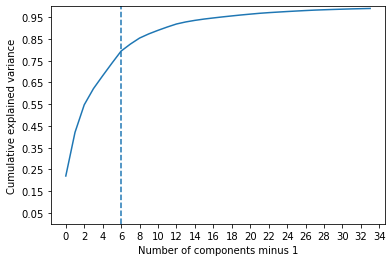

In [50]:
%%time
# do a PCA and look at the cumulative variance plot
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data_zs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components minus 1')
plt.ylabel('Cumulative explained variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=6, linestyle='--')
plt.ylim(0,1)

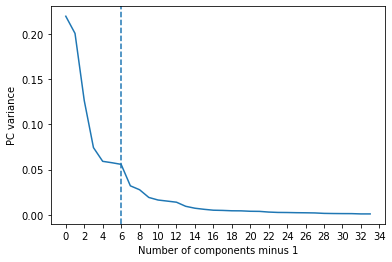

In [51]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=6, linestyle='--')

In [52]:
%%time
# now redo the PCA but just keep the top few PCs
data_zs = data_zs_save.copy()
pca = PCA(n_components = 7, svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

CPU times: user 27.6 s, sys: 800 ms, total: 28.4 s
Wall time: 28.2 s


7

In [53]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.21987302 0.42074554 0.54728944 0.62168858 0.68089473 0.73854881
 0.79441562]


In [54]:
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1046826, 7)

In [55]:
data_pca.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,7.812986,0.782459,-1.692937,0.098349,0.809687,-4.945516,2.719589
1,118.084854,9.786138,199.378118,0.399513,6.409308,-47.300143,27.856300
2,0.236833,-0.261303,0.707700,0.005826,0.003594,0.316049,-0.160373
3,0.834013,-0.204194,1.435032,0.008552,0.035698,0.083755,-0.026838
4,2.085611,-0.089649,2.951878,0.020970,0.159003,-0.774737,0.453820


In [56]:
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
count,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06
mean,1.572606e-15,-3.111344e-17,3.903006e-16,3.586924e-16,-1.199201e-15,2.566712e-16,3.447716e-16
std,4.448435e+00,4.251885e+00,3.374752e+00,2.587648e+00,2.308366e+00,2.277909e+00,2.242323e+00
min,-2.293067e+02,-3.645505e-01,-7.664554e+02,-7.165028e+02,-7.013362e+02,-5.260210e+02,-7.315593e+02
25%,-4.607729e-01,-2.158022e-01,-5.202718e-01,-6.543507e-03,-4.904047e-02,-3.033607e-01,-2.874438e-01
50%,-7.852356e-02,-1.900084e-01,-2.034711e-01,6.802326e-03,2.332644e-02,-4.028889e-02,-6.883125e-02
75%,1.745691e-01,-1.520397e-01,1.047161e-01,2.419782e-02,7.298279e-02,6.243616e-01,8.824867e-02
max,3.036422e+03,1.683254e+03,1.093464e+03,2.126744e+03,1.020287e+03,1.181004e+03,7.825028e+02


In [57]:
# zscale the pcs
data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca_zs.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
count,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06
mean,-1.185916e-15,5.167992e-17,-2.243832e-15,8.902511e-17,6.074120e-16,-7.792607e-16,-1.859007e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.154774e+01,-8.573855e-02,-2.271146e+02,-2.768935e+02,-3.038236e+02,-2.309228e+02,-3.262506e+02
25%,-1.035809e-01,-5.075447e-02,-1.541659e-01,-2.528747e-03,-2.124467e-02,-1.331751e-01,-1.281902e-01
50%,-1.765195e-02,-4.468804e-02,-6.029215e-02,2.628768e-03,1.010517e-02,-1.768679e-02,-3.069640e-02
75%,3.924282e-02,-3.575819e-02,3.102926e-02,9.351279e-03,3.161665e-02,2.740942e-01,3.935591e-02
max,6.825822e+02,3.958843e+02,3.240133e+02,8.218831e+02,4.419954e+02,5.184597e+02,3.489697e+02


In [58]:
data_pca_zs.shape

(1046826, 7)

In [59]:
data_pca_zs.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,1.756345,0.184026,-0.501648,0.038007,0.350762,-2.171078,1.212844
1,26.545259,2.301600,59.079339,0.154392,2.776556,-20.764725,12.422965
2,0.053240,-0.061456,0.209704,0.002252,0.001557,0.138745,-0.071521
3,0.187485,-0.048024,0.425226,0.003305,0.015465,0.036769,-0.011969
4,0.468842,-0.021084,0.874695,0.008104,0.068881,-0.340109,0.202388


## Now calculate two unsupervised fraud scores

In [60]:
# Set the powers for the two Minkowski distance. the final resulrts are relatively insensitive to these choices. 
# Good choices are anywhere from 1 to about 4.
p1 = 2
p2 = 2
ntop = 1000

### calculate score 1

In [61]:
oop1 = 1/p1
score1 = (((data_pca_zs).abs()**p1).sum(axis=1))**oop1
score1.head(10)

0     3.111159
1    69.235492
2     0.273789
3     0.469062
4     1.070884
5     0.428559
6     0.284815
7     0.295393
8     0.764182
9     0.733115
dtype: float64

In [62]:
score1.max()

940.878002213743

(0.1, 2089567.4539268154)

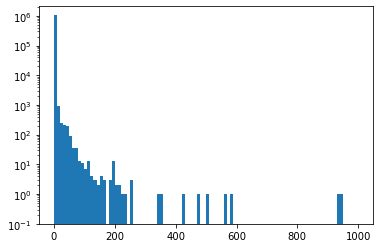

In [63]:
plt.hist(score1, bins =100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

### Autoencoder for score 2

In [64]:
NNmodel = MLPRegressor(hidden_layer_sizes=(10),activation='relu',verbose=True,max_iter=15, random_state=1)
NNmodel.fit(data_pca_zs,data_pca_zs)

Iteration 1, loss = 0.31203909
Iteration 2, loss = 0.15880255
Iteration 3, loss = 0.10783790
Iteration 4, loss = 0.08697483
Iteration 5, loss = 0.05928352
Iteration 6, loss = 0.03834116
Iteration 7, loss = 0.02695220
Iteration 8, loss = 0.01765546
Iteration 9, loss = 0.01269320
Iteration 10, loss = 0.00949307
Iteration 11, loss = 0.00595564
Iteration 12, loss = 0.00330296
Iteration 13, loss = 0.00309626
Iteration 14, loss = 0.00168802
Iteration 15, loss = 0.00106744


/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=10, max_iter=15, random_state=1, verbose=True)

In [65]:
# calculate score 2 as the autoencoder error
pca_out = NNmodel.predict(data_pca_zs)
error = pca_out - data_pca_zs
oop2=1/p2
score2 = ((error.abs()**p2).sum(axis=1))**oop2

In [66]:
score2.head(10)

0    0.032713
1    1.062363
2    0.023396
3    0.025584
4    0.030607
5    0.018652
6    0.021399
7    0.021219
8    0.028483
9    0.028171
dtype: float64

In [67]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['RECORD'] = save_record
scores.head(10)

,score1,score2,RECORD
0,3.111159,0.032713,1
1,69.235492,1.062363,2
2,0.273789,0.023396,9
3,0.469062,0.025584,10
4,1.070884,0.030607,11
5,0.428559,0.018652,12
6,0.284815,0.021399,13
7,0.295393,0.021219,14
8,0.764182,0.028483,15
9,0.733115,0.028171,16


In [68]:
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank
0,3.111159,0.032713,1,1033738.0,924622.0
1,69.235492,1.062363,2,1046696.0,1046048.0
2,0.273789,0.023396,9,573498.0,762788.0
3,0.469062,0.025584,10,752401.0,809187.0
4,1.070884,0.030607,11,1004165.0,900752.0
5,0.428559,0.018652,12,715004.0,648262.0
6,0.284815,0.021399,13,586879.0,716800.0
7,0.295393,0.021219,14,598828.0,712164.0
8,0.764182,0.028483,15,980717.0,868128.0
9,0.733115,0.028171,16,976676.0,862006.0


In [69]:
# calculate the final score as the average of the two scores
scores['final'] = (.5*scores['score1 rank'] + .5*scores['score2 rank'])
scores_sorted = scores.sort_values(by='final', ascending=False)
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank,final
0,3.111159,0.032713,1,1033738.0,924622.0,979180.0
1,69.235492,1.062363,2,1046696.0,1046048.0,1046372.0
2,0.273789,0.023396,9,573498.0,762788.0,668143.0
3,0.469062,0.025584,10,752401.0,809187.0,780794.0
4,1.070884,0.030607,11,1004165.0,900752.0,952458.5
5,0.428559,0.018652,12,715004.0,648262.0,681633.0
6,0.284815,0.021399,13,586879.0,716800.0,651839.5
7,0.295393,0.021219,14,598828.0,712164.0,655496.0
8,0.764182,0.028483,15,980717.0,868128.0,924422.5
9,0.733115,0.028171,16,976676.0,862006.0,919341.0


In [70]:
scores_sorted.head(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
975628,933.839091,220.745250,996722,1046825.0,1046826.0,1046825.5
898846,940.878002,71.691718,917942,1046826.0,1046825.0,1046825.5
675033,581.345073,38.365287,691986,1046824.0,1046823.0,1046823.5
701673,504.329968,35.713909,718883,1046822.0,1046821.0,1046821.5
633064,358.966984,68.591168,649717,1046819.0,1046824.0,1046821.5
1031078,207.927065,36.696732,1053859,1046810.0,1046822.0,1046816.0
759739,257.550518,29.588648,777200,1046817.0,1046808.0,1046812.5
936080,560.374108,14.148275,956520,1046823.0,1046798.0,1046810.5
642176,424.225756,14.551821,658933,1046820.0,1046799.0,1046809.5
7010,199.864449,34.514530,7034,1046803.0,1046815.0,1046809.0


In [71]:
scores_sorted.tail(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
511461,0.058393,0.002424,527096,634.0,4171.0,2402.5
400344,0.058735,0.002415,415065,741.0,4048.0,2394.5
400478,0.058940,0.002409,415199,790.0,3974.0,2382.0
715195,0.060575,0.002320,732459,1627.0,3116.0,2371.5
400356,0.059635,0.002371,415077,1135.0,3560.0,2347.5
790582,0.061518,0.002204,808270,2278.0,2182.0,2230.0
602929,0.060541,0.002276,619299,1601.0,2783.0,2192.0
693112,0.060692,0.002262,710272,1689.0,2671.0,2180.0
779344,0.058971,0.002339,796921,798.0,3294.0,2046.0
800821,0.058892,0.002300,818560,778.0,2979.0,1878.5


In [72]:
scores.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06
mean,4.527606e-01,2.350189e-02,5.371221e+05,5.234135e+05,5.234135e+05,5.234135e+05
std,2.606724e+00,2.909071e-01,3.080878e+05,3.021928e+05,3.021928e+05,2.813945e+05
min,4.744451e-02,1.009656e-03,1.000000e+00,1.000000e+00,1.500000e+00,1.878500e+03
25%,1.450990e-01,7.607892e-03,2.731562e+05,2.617072e+05,2.617072e+05,2.821678e+05
50%,2.404222e-01,1.366771e-02,5.390825e+05,5.234135e+05,5.234095e+05,5.000905e+05
75%,5.027798e-01,2.440871e-02,8.027368e+05,7.851198e+05,7.851195e+05,7.735816e+05
max,9.408780e+02,2.207453e+02,1.070994e+06,1.046826e+06,1.046826e+06,1.046826e+06


In [73]:
scores_sorted.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06
mean,4.527606e-01,2.350189e-02,5.371221e+05,5.234135e+05,5.234135e+05,5.234135e+05
std,2.606724e+00,2.909071e-01,3.080878e+05,3.021928e+05,3.021928e+05,2.813945e+05
min,4.744451e-02,1.009656e-03,1.000000e+00,1.000000e+00,1.500000e+00,1.878500e+03
25%,1.450990e-01,7.607892e-03,2.731562e+05,2.617072e+05,2.617072e+05,2.821678e+05
50%,2.404222e-01,1.366771e-02,5.390825e+05,5.234135e+05,5.234095e+05,5.000905e+05
75%,5.027798e-01,2.440871e-02,8.027368e+05,7.851198e+05,7.851195e+05,7.735816e+05
max,9.408780e+02,2.207453e+02,1.070994e+06,1.046826e+06,1.046826e+06,1.046826e+06


In [74]:
scores_sorted.set_index('RECORD', drop=True, inplace=True)
scores_sorted.head(10)

,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,
996722,933.839091,220.745250,1046825.0,1046826.0,1046825.5
917942,940.878002,71.691718,1046826.0,1046825.0,1046825.5
691986,581.345073,38.365287,1046824.0,1046823.0,1046823.5
718883,504.329968,35.713909,1046822.0,1046821.0,1046821.5
649717,358.966984,68.591168,1046819.0,1046824.0,1046821.5
1053859,207.927065,36.696732,1046810.0,1046822.0,1046816.0
777200,257.550518,29.588648,1046817.0,1046808.0,1046812.5
956520,560.374108,14.148275,1046823.0,1046798.0,1046810.5
658933,424.225756,14.551821,1046820.0,1046799.0,1046809.5


(0.1, 2089149.628010629)

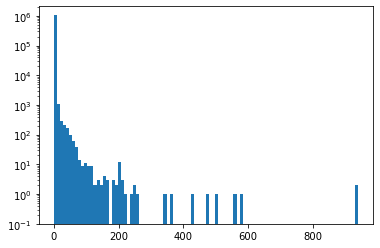

In [75]:
sc1max = int(score1.max())
plt.hist(score1, bins =100, range=(0,sc1max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

In [76]:
sc2max = int(score2.max())
sc2max

220

220


(0.1, 2092817.813427145)

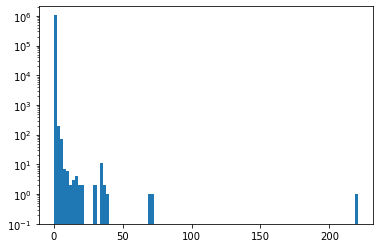

In [77]:
sc2max = int(score2.max())
print(sc2max)
plt.hist(score2, bins =100, range=(0,sc2max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

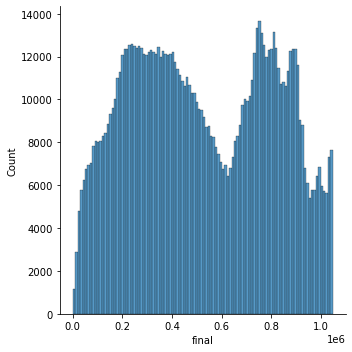

In [78]:
sns.displot(scores['final'])

In [79]:
top_records = scores_sorted.head(ntop).index
print(top_records)

Int64Index([ 996722,  917942,  691986,  718883,  649717, 1053859,  777200,
             956520,  658933,    7034,
            ...
             284190,  284200,  284201,  284211,  284198,  284202,  284210,
             284180,  284189,  284205],
           dtype='int64', name='RECORD', length=1000)


In [80]:
data_zs['RECORD'] = save_record
data_zs.set_index('RECORD', inplace=True, drop=True)
data_zs.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,...,r9_boro,r1inv_boro,r2inv_boro,r3inv_boro,r4inv_boro,r5inv_boro,r6inv_boro,r7inv_boro,r8inv_boro,r9inv_boro
RECORD,,,,,,,,,,,,,,,,,,,,,
1,-0.324189,3.365634,0.962071,-0.034088,2.023461,0.745320,-0.041301,1.874086,0.937911,-0.015279,...,0.887478,-0.015678,-0.022354,-0.020917,-0.018898,-0.051015,-0.033996,-0.014258,-0.040323,-0.046264
2,107.903135,34.685411,12.654552,60.713604,6.996480,2.658471,127.179921,17.407961,8.963675,-0.019486,...,8.549314,-0.017466,-0.022386,-0.020925,-0.019644,-0.051036,-0.034000,-0.015962,-0.040385,-0.046283
9,0.322241,0.194554,-0.459794,0.738056,0.253399,-0.042992,0.718576,0.301305,-0.038062,-0.019041,...,-0.044240,-0.017277,-0.022189,-0.020469,-0.019548,-0.050851,-0.033701,-0.015782,-0.040014,-0.045241
10,0.644229,0.513596,-0.446651,1.133208,0.393046,-0.037064,1.097074,0.459542,-0.029041,-0.019179,...,-0.035628,-0.017335,-0.022251,-0.020609,-0.019578,-0.050911,-0.033794,-0.015838,-0.040131,-0.045563
11,1.542460,1.403606,-0.409988,1.200500,0.416827,-0.036055,2.152944,0.900967,-0.003875,-0.019322,...,-0.011603,-0.017396,-0.022316,-0.020756,-0.019582,-0.050917,-0.033804,-0.015896,-0.040252,-0.045897


In [81]:
data_zs_top_n = data_zs.loc[top_records]
data_zs_top_n.transpose()

RECORD,996722,917942,691986,718883,649717,1053859,777200,956520,658933,7034,...,284190,284200,284201,284211,284198,284202,284210,284180,284189,284205
r1,-0.401017,0.748372,-0.401020,-0.401019,-0.401020,-0.401020,-0.401019,-0.113628,0.181820,-0.401018,...,-0.400562,-0.400562,-0.400562,-0.400562,-0.400562,-0.400562,-0.400562,-0.400562,-0.400562,-0.400562
r2,-0.522013,67.425821,-0.522087,-0.522087,-0.522084,-0.522006,-0.522086,-0.522051,-0.522034,-0.522086,...,-0.521634,-0.521634,-0.521634,-0.521634,-0.521634,-0.521634,-0.521634,-0.521634,-0.521634,-0.521634
r3,-0.489278,46.162233,-0.489316,-0.489316,-0.489314,-0.489285,-0.489315,-0.489290,-0.489279,-0.489316,...,-0.489238,-0.489238,-0.489238,-0.489238,-0.489238,-0.489238,-0.489238,-0.489238,-0.489238,-0.489238
r4,-0.149547,41.781054,-0.149533,-0.062929,-0.149544,-0.149544,-0.149536,-0.051554,0.004449,-0.149545,...,-0.149522,-0.149522,-0.149522,-0.149522,-0.149522,-0.149522,-0.149522,-0.149522,-0.149522,-0.149522
r5,-0.060280,884.036490,-0.060276,-0.035784,-0.060276,-0.060181,-0.060276,-0.060277,-0.060276,-0.060280,...,-0.060272,-0.060272,-0.060272,-0.060272,-0.060272,-0.060272,-0.060272,-0.060272,-0.060272,-0.060272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
r5inv_boro,174.972244,-0.051044,37.928851,-0.043399,37.928851,1.363554,37.928851,31.202957,36.789271,109.304763,...,14.631679,14.631679,14.631679,14.631679,14.631679,14.631679,14.631679,14.631679,14.631679,14.631679
r6inv_boro,103.273998,-0.034001,19.530223,-0.024008,19.530223,1.117686,19.530223,13.801822,10.284823,44.181253,...,9.286954,9.286954,9.286954,9.286954,9.286954,9.286954,9.286954,9.286954,9.286954,9.286954
r7inv_boro,944.698744,-0.015956,51.928600,74.017774,243.139595,38.765429,69.414815,-0.015106,-0.013240,45.805818,...,0.479192,0.479192,0.479192,0.479192,0.479192,0.479192,0.479192,0.479192,0.479192,0.479192
r8inv_boro,159.761215,-0.040393,79.717483,142.004459,79.717483,1.251178,79.717483,21.267255,44.723493,119.850219,...,0.772396,0.772396,0.772396,0.772396,0.772396,0.772396,0.772396,0.772396,0.772396,0.772396


In [82]:
scores.set_index('RECORD',inplace=True)
scores.drop(columns=['score1','score2'],inplace=True)
scores.head(30)

,score1 rank,score2 rank,final
RECORD,,,
1,1033738.0,924622.0,979180.0
2,1046696.0,1046048.0,1046372.0
9,573498.0,762788.0,668143.0
10,752401.0,809187.0,780794.0
11,1004165.0,900752.0,952458.5
12,715004.0,648262.0,681633.0
13,586879.0,716800.0,651839.5
14,598828.0,712164.0,655496.0
15,980717.0,868128.0,924422.5


In [83]:
# NY_data_with_scores = NY_data_orig.join(scores, on='RECORD', rsuffix='_scores')
NY_data_with_scores = NY_data_orig.join(scores, on='RECORD')
NY_data_with_scores.set_index('RECORD',inplace=True)
NY_data_with_scores.head(10)

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
RECORD,,,,,,,,,,,,,,,,,,,,,
1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,1033738.0,924622.0,979180.0
2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,1046696.0,1046048.0,1046372.0
3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,1260,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
6,1000030002,1,3,2,NaN,PARKS AND RECREATION,Q1,4,496,76,...,4268700.0,4268700.0,4268700.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
7,1000030003,1,3,3,NaN,PARKS AND RECREATION,Q1,4,180,370,...,3546900.0,3546900.0,3546900.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
8,1000030010,1,3,10,NaN,DEPT RE-CITY OF NY,Z9,4,362,177,...,11304000.0,9882000.0,11304000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,0,0,...,2049290.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR,573498.0,762788.0,668143.0


In [84]:
NY_data_top_n = NY_data_with_scores.sort_values(['final'], ascending = False).head(ntop)
NY_data_top_n

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
RECORD,,,,,,,,,,,,,,,,,,,,,
996722,5029220125,5,2922,125,NaN,IMPERIAL COURT HOMEOW,V0,1B,300,400,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046825.0,1046826.0,1046825.5
917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,0,...,4.501180e+09,1.644454e+09,4.501180e+09,NaN,FINAL,2010/11,AC-TR,1046826.0,1046825.0,1046825.5
691986,4039160200,4,3916,200,NaN,TITAN SOUNDVIEW POINT,Z7,4,0,0,...,3.000000e+00,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046824.0,1046823.0,1046823.5
718883,4051251107,4,5125,1107,NaN,GARDEN VIEW LTD,R4,2,0,0,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046822.0,1046821.0,1046821.5
649717,4025270002,4,2527,2,NaN,57-43 LLC,V1,4,51,940,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046819.0,1046824.0,1046821.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284202,3009641270,3,964,1270,NaN,NaN,R5,4,0,0,...,1.123000e+03,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1044790.0,1046156.0,1045473.0
284210,3009641278,3,964,1278,NaN,NaN,R5,4,0,0,...,1.123000e+03,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1044790.0,1046156.0,1045473.0
284180,3009641248,3,964,1248,NaN,NaN,R5,4,0,0,...,1.123000e+03,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1044790.0,1046156.0,1045473.0


In [85]:
NY_data_top_n['OWNER'].head(40)

RECORD
996722     IMPERIAL COURT HOMEOW
917942      LOGAN PROPERTY, INC.
691986     TITAN SOUNDVIEW POINT
718883           GARDEN VIEW LTD
649717                 57-43 LLC
1053859                      NaN
777200     NY STATE PUBLIC WORKS
956520         TROMPETA RIZALINA
658933           WAN CHIU CHEUNG
7034              HSIA, JONATHAN
995567                       NaN
7040            BILINKAS, EDWARD
7039              LAMBERT, PETER
7038               OWEN, MICHAEL
7037                 HANLON, AMY
7036             LECH, JOHN PAUL
7035                NOVARO, HUGO
7042           SWENDSRUD, MONICA
7041                         NaN
7033                         NaN
7043                CHOI, JOSEPH
459429                       NaN
934793     BREEZY POINT COOPERAT
243059      SILVER BEACH GARDENS
114694                       NaN
1059883                      NaN
1048475    PARK VILLAGE RESIDENT
845810           WILLIAM A. LOTT
241946       RUFFALO ENTERPRISES
1000954    MATIONAL COLLECTORS &
665

In [86]:
NY_data_top_n.shape

(1000, 34)

In [87]:
data_zs_top_n.shape

(1000, 90)

In [88]:
NY_top_with_zs = pd.concat([NY_data_top_n,data_zs_top_n],axis=1)
NY_top_with_zs.shape

(1000, 124)

In [89]:
NY_top_with_zs.to_excel('NY_top_with_zs.xlsx', index=True)
NY_data_top_n.to_excel('NY_top.xlsx', index=True)
data_zs_top_n.to_csv('data_zs_top.csv', index=True)

In [90]:
data_zs_top_n.shape

(1000, 90)

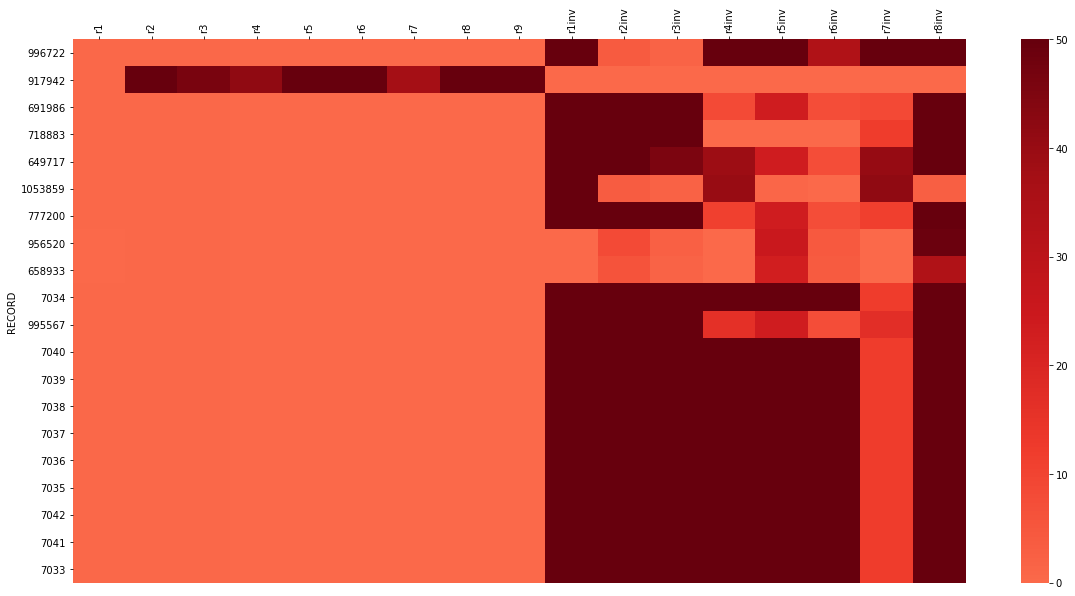

In [91]:
# The heatmaps are good for seeing which variables are driving the high scores
data_base_vars = data_zs_top_n.iloc[:,0:17].abs()
data_heatmap = data_base_vars.head(20)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

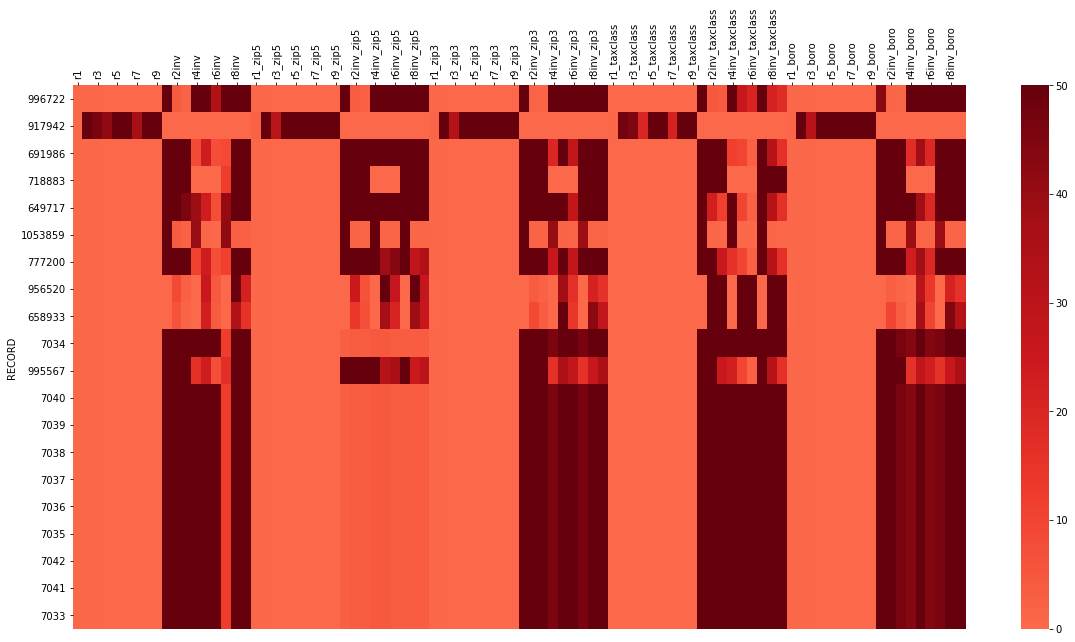

In [92]:
data_zs_top_n_abs = data_zs_top_n.abs()
data_heatmap = data_zs_top_n.abs().head(20)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [93]:
top_records_df = pd.DataFrame(top_records)

In [94]:
# Use this cell if you want to write out the top n record numbers
top_records_df.to_csv('top_n_record_numbers.csv', index=False)

In [95]:
# # Use this cell if you want to compare to a previous top n record numbers.
# # You can run a baseline model, see which records score the highest, then change some of the algorithm parameters
# # to see what % of these top scoring records change. The top records are insensitive to changes in the 
# # powers for the Minkowski distance measures for the two scores

# top_records_previous = pd.read_csv('top_n_record_numbers.csv')
# print(top_records_df.head())
# print(top_records_previous.head())
# num_common = len(pd.merge(top_records_df,top_records_previous, on='RECORD'))
# percent_common = 100*num_common/ntop
# percent_common

In [96]:
print('Duration: ', datetime.now() - start_time)

Duration:  0:03:02.847779
